In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from scipy.stats import norm
from collections import Counter

def read_dataset(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['label'].to_numpy()
    X = df.drop('label', axis=1).to_numpy()
    return X, y

def scale_data(data):
    return MinMaxScaler().fit_transform(data) 

def read_regression(path):
    df = pd.read_csv(path, skiprows=0)
    y = df['y'].to_numpy()
    X = df.drop('y', axis=1).to_numpy()
    return X, y

X_sin, y_sin = read_regression('noisysine.csv')
X_hyd, y_hyd = read_regression('hydrodynamics.csv')



**Regression**

In [3]:
def regression(X, y, poly_features=1):
    poly = PolynomialFeatures(poly_features)
    X = poly.fit_transform(X)
    
    w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), X.transpose()), y)
    return w

def draw_regression(X_train, X_test, y_train, y_test, w, equation, title):
    plt.cla()
    plt.scatter(X_train, y_train, s=4)
    plt.scatter(X_test, y_test, s=4)
    
    delta = 0.025
    xrange = np.arange(np.min(X_train) - 0.5, np.max(X_train) + 0.5, delta)
    yrange = np.arange(np.min(y_train) - 0.5, np.max(y_train) + 0.5, delta)
    X, Y = np.meshgrid(xrange, yrange)
    Z = equation(X, Y, w) 
    plt.contour(X, Y, Z, [0])
    plt.title(title)
    plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_sin, y_sin, test_size=0.2)

def calc_R2(X, y, w, degree):
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(X)
    y_avg = np.average(y)
    v = np.sum((y - y_avg) ** 2)
    u = np.sum((np.dot(X, w) - y) ** 2)
    return 1 - u / v

def do_regression(degree, equation):
    w = regression(X_train, y_train, degree)
    print(f"R^2 score train: {calc_R2(X_train, y_train, w, degree)} \t test: {calc_R2(X_test, y_test, w, degree)}")
    draw_regression(X_train, X_test, y_train, y_test, w, equation, f"degree {degree}")

R^2 score train: 0.19381967442262904 	 test: -0.02392246900668482


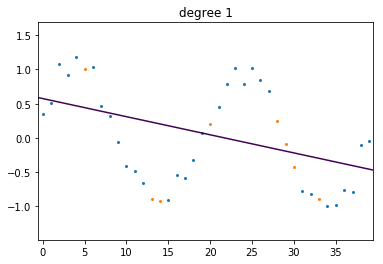

In [4]:
do_regression(1, lambda x, y, w: w[0] + x * w[1] - y)

R^2 score train: 0.19383075662122218 	 test: -0.02621617160933476


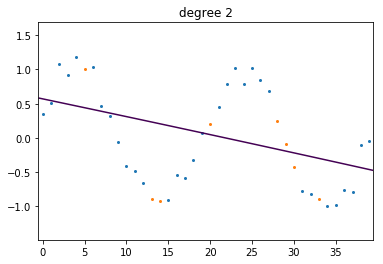

In [5]:
do_regression(2, lambda x, y, w: w[0] + x * w[1] + x**2 * w[2] - y)

R^2 score train: 0.3006593804151465 	 test: 0.10795334329194084


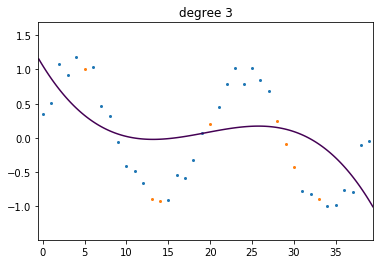

In [6]:
do_regression(3, lambda x, y, w: w[0] + x * w[1] + x**2 * w[2] + x ** 3 * w[3] - y)

R^2 score train: 0.3185599527092664 	 test: 0.13285912749366535


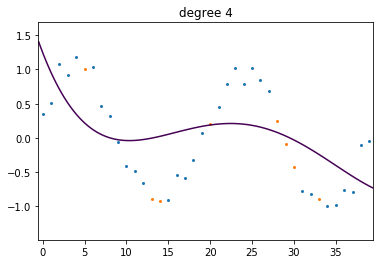

In [7]:
do_regression(4, lambda x, y, w: w[0] + x * w[1] + x**2 * w[2] + x ** 3 * w[3] + x ** 4 * w[4] - y)

R^2 score train: 0.9027234763461087 	 test: 0.8100926461741591


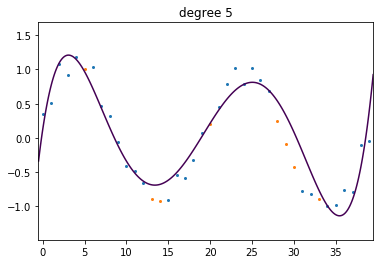

In [8]:
do_regression(5, lambda x, y, w: w[0] + x * w[1] + x**2 * w[2] + x ** 3 * w[3] + x ** 4 * w[4] + x** 5 * w[5] - y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_hyd, y_hyd, test_size=0.2)

In [10]:
w = regression(X_train, y_train, 1)
print("linear regression")
print(f"R^2 score train: {calc_R2(X_train, y_train, w, 1)} \t test: {calc_R2(X_test, y_test, w, 1)}")

linear regression
R^2 score train: 0.6632976926891847 	 test: 0.6296358529793424


In [11]:
w = regression(X_train, y_train, 2)
print("poly2 regression")
print(f"R^2 score train: {calc_R2(X_train, y_train, w, 2)} \t test: {calc_R2(X_test, y_test, w, 2)}")

poly2 regression
R^2 score train: 0.9338464514379075 	 test: 0.9087025692026628


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_sin, y_sin, test_size=0.2)

def ridge_regression(X, y, degree, alpha):
    poly = PolynomialFeatures(degree)
    X = poly.fit_transform(X)
    XTX = np.matmul(X.transpose(), X)
    XTy = np.matmul(X.transpose(), y)
    w = np.matmul(np.linalg.inv(XTX - alpha * np.eye(X.shape[1])), XTy)
    return w

def do_ridge_regression(degree, equation, draw=True):
    best_alpha, best_r2 = None, -1e9
    for alpha in np.linspace(0, 10, 10000):
        w = ridge_regression(X_train, y_train, degree, alpha)
        r2 = calc_R2(X_test, y_test, w, degree)
        if r2 > best_r2:
            best_alpha, best_r2 = alpha, r2
    w = ridge_regression(X_train, y_train, degree, best_alpha)    
    print(f"Alpha is {best_alpha}")
    print(f"R^2 score train: {calc_R2(X_train, y_train, w, degree)} \t test: {calc_R2(X_test, y_test, w, degree)}")
    if draw:
        draw_regression(X_train, X_test, y_train, y_test, w, equation, f"degree {degree}")

Alpha is 0.0
R^2 score train: 0.2194609084248137 	 test: -0.002045838875755601


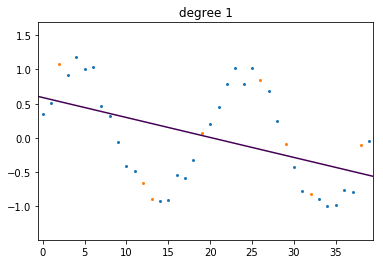

In [95]:
do_ridge_regression(1, lambda x, y, w: w[0] + x * w[1] - y)

Alpha is 1.5151515151515151
R^2 score train: 0.19285620445469132 	 test: 0.003938960880267572


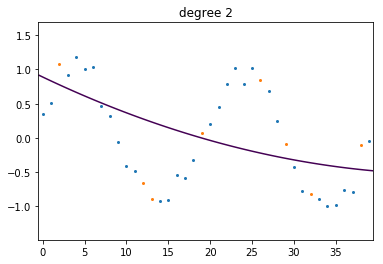

In [96]:
do_ridge_regression(2, lambda x, y, w: w[0] + x * w[1] + x ** 2 * w[2] - y)

Alpha is 0.8900890089008902
R^2 score train: 0.24993746475299283 	 test: 0.2528497581970546


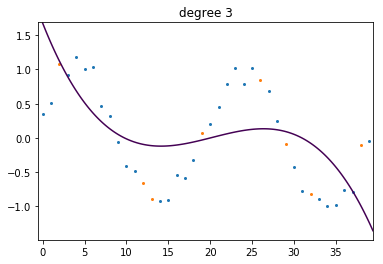

In [97]:
do_ridge_regression(3, lambda x, y, w: w[0] + x * w[1] + x ** 2 * w[2] + x ** 3 * w[3] - y)

Alpha is 1.0151015101510152
R^2 score train: -0.007405365289348209 	 test: 0.462849552153499


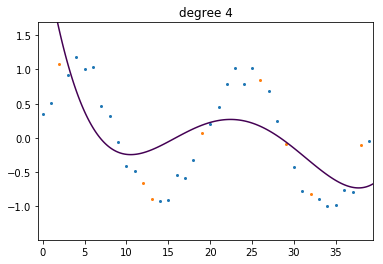

In [99]:
do_ridge_regression(4, lambda x, y, w: w[0] + x * w[1] + x ** 2 * w[2] + x ** 3 * w[3] + x ** 4 * w[4] - y)

Alpha is 0.47004700470047006
R^2 score train: 0.8944548980994376 	 test: 0.8831839086668993


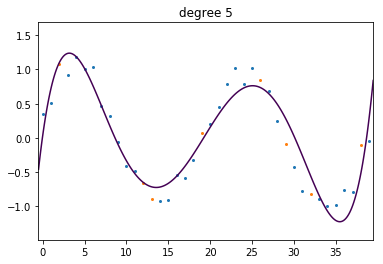

In [100]:
do_ridge_regression(5, lambda x, y, w: w[0] + x * w[1] + x ** 2 * w[2] + x ** 3 * w[3] + x ** 4 * w[4] + x ** 5 * w[5]- y)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_hyd, y_hyd, test_size=0.2)

In [107]:
do_ridge_regression(1, lambda x, y, w: w[0] + x * w[1] - y, draw=False)

Alpha is 0.11501150115011502
R^2 score train: 0.6336980891239159 	 test: 0.7223610783346037


In [109]:
do_ridge_regression(2, lambda x, y, w: w[0] + x * w[1] + x ** 2 * w[2] - y, draw=False)

Alpha is 0.0
R^2 score train: 0.924705841010114 	 test: 0.9435512750323314


In [129]:
from sklearn.linear_model import Lasso
def lasso_regression(X_train, y_train, degree, alpha):
    poly = PolynomialFeatures(degree)
    X_train = poly.fit_transform(X_train)
    lasso = Lasso(normalize=True, alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    return lasso.coef_
    
def do_lasso(X_train, y_train, X_test, y_test, equation, degree=1, draw=True):
    best_alpha, best_r2 = None, -1e9
    for alpha in np.linspace(0, 10, 10000):
        w = lasso_regression(X_train, y_train, degree, alpha)
        r2 = calc_R2(X_test, y_test, w, degree)
        if r2 > best_r2:
            best_alpha, best_r2 = alpha, r2
    w = lasso_regression(X_train, y_train, degree, best_alpha)
    print(f"Used {np.sum(w != 0)} out of {w.shape[0]} features, alpha is {alpha}")
    print(f"R^2 score train: {calc_R2(X_train, y_train, w, degree)} \t test: {calc_R2(X_test, y_test, w, degree)}")
    if draw:
        draw_regression(X_train, X_test, y_train, y_test, w, equation, f"degree {degree}")

X_train, X_test, y_train, y_test = train_test_split(X_sin, y_sin, test_size=0.2)

/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Used 1 out of 2 features, alpha is 10.0
R^2 score train: 0.04299449015890866 	 test: -0.013013209919526147


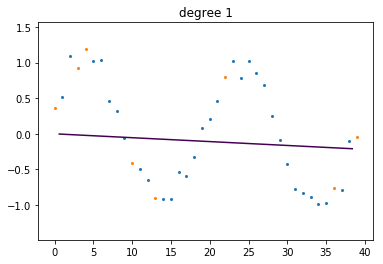

/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Used 1 out of 3 features, alpha is 10.0
R^2 score train: 0.04299449015890866 	 test: -0.013013209919526147


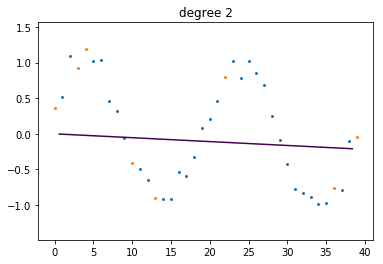

/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Used 2 out of 4 features, alpha is 10.0
R^2 score train: 0.055498510750068175 	 test: -0.007529460202547744


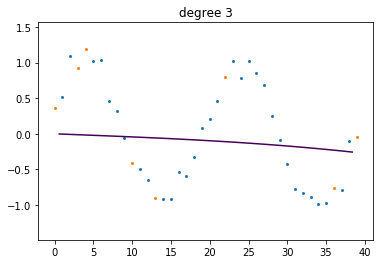

/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Used 2 out of 5 features, alpha is 10.0
R^2 score train: 0.0712750954876421 	 test: -0.0002600746819982902


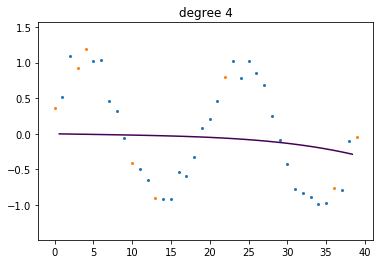

/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Used 2 out of 6 features, alpha is 10.0
R^2 score train: 0.0718681691931653 	 test: 0.00014853446153795247


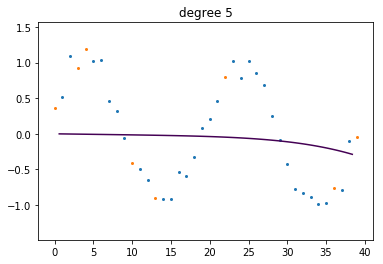

In [130]:
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] - y, degree=1)
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] + x ** 2 *  w[2] - y, degree=2)
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] + x ** 2 *  w[2] + x ** 3 *  w[3] - y, degree=3)
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] + x ** 2 *  w[2] + x ** 3 *  w[3] + x ** 4* w[4] - y, degree=4)
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] + x ** 2 *  w[2] + x ** 3 *  w[3] + x ** 4* w[4] + x ** 5* w[5] - y, degree=5)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_hyd, y_hyd, test_size=0.2)
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] - y, degree=1, alpha=0.1, draw=False)
do_lasso(X_train, y_train, X_test, y_test, lambda x, y, w: w[0] + x * w[1] + x ** 2 *  w[2] - y, degree=2, alpha=0.1, draw=False)

Used 1 out of 7 features
R^2 score train: -1.0899078550760097 	 test: -0.40531998354208576
Used 1 out of 28 features
R^2 score train: 0.4802857382672633 	 test: 0.6076179489329175


**Global and Local Search**

In [79]:
def read_tsp(path):
    df = pd.read_csv(path, header=None, usecols=[1, 2])
    X = df.to_numpy()
    return X

X = read_tsp('tsp.csv')

def find_length(order):
    dist = np.abs(order[:-1] - np.roll(order, -1, axis=0)[:-1])
    return np.sum(dist)

def draw_path(order):
    plt.cla()
    dist = np.abs(order[:-1] - np.roll(order, -1, axis=0)[:-1])
    print(f"Distance is {np.sum(dist)}")
    l1_order = []
    for i in range(X.shape[0] - 1):
        l1_order.append(X[i])
        l1_order.append([X[i, 0], X[i + 1, 1]])
    l1_order = np.array(l1_order)
    plt.plot(l1_order[:, 0], l1_order[:, 1])
    plt.show()
    
def hill_climb(X):
    cur_dist = find_length(X)
    finished = False
    while not finished:
        finished = True
        for i in range(X.shape[0]):
            for j in range(i + 1, X.shape[0]):
                X[[i, j]] = X[[j, i]] 
                if find_length(X) < cur_dist:
                    cur_dist = find_length(X)
                    finished = False
                else:
                    X[[i, j]] = X[[j, i]] # swap back
        return X

def monte_carlo(X, iterations=100000):
    best_ans, best_dist = None, 1e9
    for i in range(iterations):
        np.random.shuffle(X)
        cur_dist = find_length(X)
        if cur_dist < best_dist:
            best_dist = cur_dist
            best_ans = X
            
    return X

def random_walk(X, iterations=10000):
    best_ans, best_dist = None, 1e9
    for _ in tqdm_notebook(range(iterations)):
        np.random.shuffle(X)
        order = [X[0]]
        used = np.zeros(X.shape[0])
        used[0] = True
        for _ in range(X.shape[0] - 1):
            dists = np.linalg.norm(X - order[-1], ord=1, axis=1)
            dists[used == True] = 1e10
            dists = 1 / dists
            nxt = np.random.choice(np.arange(X.shape[0]), p=dists / np.sum(dists))
            order.append(X[nxt])
            used[nxt] = True
        
        order = np.array(order)
        cur_dist = find_length(order)
        if cur_dist < best_dist:
            best_dist = cur_dist
            best_ans = order
            
    return best_ans

def annealing(X, iterations=1000):
    for t in tqdm_notebook(range(iterations, 0, -1)):
        choices = []
        dists = []
        cur_dist = find_length(X)
        for i in range(X.shape[0]):
            for j in range(i + 1, X.shape[0]):
                choices.append([i, j])
                X[[i, j]] = X[[j, i]]
                dists.append(cur_dist - find_length(X))
                X[[i, j]] = X[[j, i]]
        dists = np.array(dists, dtype='float32')
        dists /= t
        dists = np.exp(dists)
        dists = np.clip(dists, 0, 1e10)
        dists /= np.sum(dists)
        action = np.random.choice(np.arange(len(choices)), p=dists)
        X[choices[action]] = X[choices[action][::-1]]
    return X


Distance is 38375


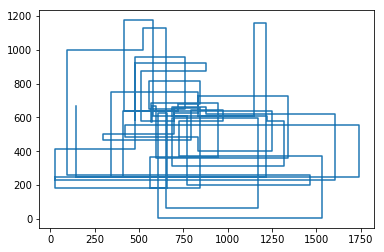

Distance is 20170


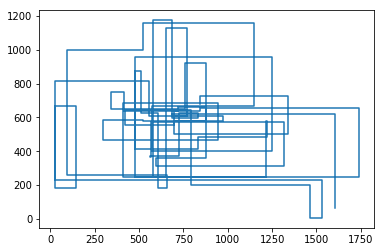

Distance is 17110


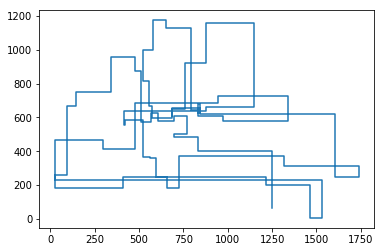

Distance is 12100


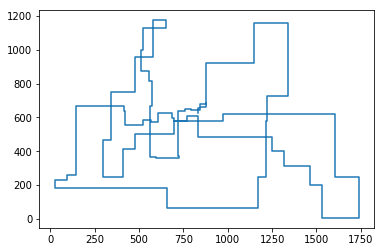

In [80]:
draw_path(monte_carlo(X))
draw_path(random_walk(X))
draw_path(hill_climb(X))
draw_path(annealing(X))   

/Users/andrey/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Distance is 10425


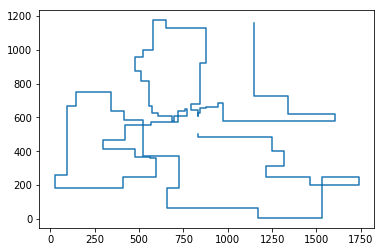

In [78]:
class GeneticAlgo:
    
    def __init__(self, X):
        self.X = X
        self.population = None
        self.length = len(X)
        self.mut_prob = 0.33
        self.expected_size = 1000
        self.best_ans = None
        self.best_dist = 1e10
    
    def do(self, iterations=1000):
        self.population = np.array([np.random.permutation(np.arange(self.length)) for _ in range(self.expected_size)])
        for _ in tqdm_notebook(range(iterations)):
            self.selection()
            self.crossover()
            self.mutation()
        return X[self.best_ans]
    
    def selection(self):
        fittness = [find_length(X[path]) for path in self.population]
        best_indices = np.argsort(fittness)
        
        if fittness[best_indices[0]] < self.best_dist:
            self.best_dist = fittness[best_indices[0]]
            self.best_ans = self.population[best_indices[0]]
        
        self.population = self.population[[best_indices[:self.expected_size // 2]]]
            
    
    def crossover(self):
        new_pop = []
        for _ in range(self.expected_size - len(self.population)):
            i = np.random.randint(len(self.population))
            j = np.random.randint(len(self.population))
            gene = np.random.randint(self.length)
            first = self.population[i][:gene]
            second = self.population[j][~np.isin(self.population[j], first)]
            new_pop.append(np.concatenate([first, second]))
        self.population = np.concatenate([self.population, new_pop])
        
    def mutation(self):
        for element in self.population:
            if np.random.uniform() < self.mut_prob:
                i, j = np.random.randint(self.length), np.random.randint(self.length)
                element[[i, j]] = element[[j, i]]
                
draw_path(GeneticAlgo(X).do())